# Answering Business Questions using SQL

We'll assume the position of The Chinook Record Store to make some business decisions.

We'll be using the Chinook dataset which contains fictional data about customers music album purchases.

The tables are:
- employee
- customer
- invoice
- invoice_line
- playlist
- playlist_track
- track
- media_type
- artist
- album
- genre

### Creating Helper Functions

We'll use two approaches to create connection objects to the SQLite database.

1. Create helper functions to save some time
2. Use **context manager** to handle the ocnnection to the SQLite database.

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3

In [2]:
%matplotlib inline

In [3]:
db = 'chinook.db'

In [4]:
# takes a SQL query as an argument and returns a pandas dataframe
def run_query(query):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(query, conn)

In [5]:
# takes a SQL query as an argument and executes it
def run_command(query):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(query)

In [6]:
# calls the run_query() function and returns a list of all tables and views in the database
def show_tables():
    query = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table", "view");
    '''
    return run_query(query)

In [7]:
show_tables() # take a look at the db tables and views

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


### Selecting Albums to Purchase

The scenario we're given here is the record store just signed a deal with a new record label and we're tasked to select the first three albums from a list of four to add to the store. None of the artists have any tracks in the store right now - all we have right now are the names and genre.

| Artist Name | Genre |
| --- | --- |
| Regal | Hip-Hop|
| Red Tone | Punk |
| Meteor and the Girls | Pop |
| Slim Jim Bites | Blues |

The record label specializes in artists from the USA so we're interested in finding which genres sell in the country.

In [8]:
usa_query ='''
WITH
	usa_purchase AS
		(
		SELECT
			inl.*
		FROM invoice AS i
		INNER JOIN customer AS c ON i.customer_id = c.customer_id
		INNER JOIN invoice_line AS inl ON i.invoice_id = inl.invoice_id
		WHERE c.country = 'USA'
		)

SELECT
	g.name as genre_name,
	COUNT(u.invoice_line_id) AS num_tracks_sold,
	CAST(COUNT(u.invoice_line_id)  AS FLOAT)/ CAST((SELECT COUNT(*) FROM usa_purchase) AS FLOAT) AS percent_sold
FROM usa_purchase AS u
INNER JOIN track as t ON u.track_id = t.track_id 
INNER JOIN genre as g ON t.genre_id = g.genre_id
GROUP BY genre_name
ORDER BY num_tracks_sold DESC 
'''

In [9]:
run_query(usa_query)

,genre_name,num_tracks_sold,percent_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


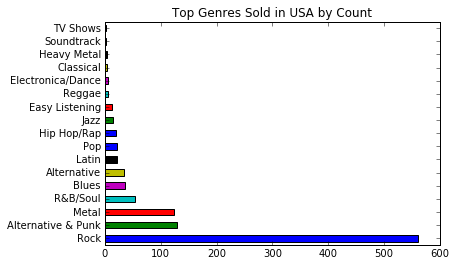

In [13]:
genre_sales_usa = run_query(usa_query)
genre_sales_usa.set_index('genre_name', inplace = True)

genre_sales_usa['num_tracks_sold'].plot.barh(
    title = 'Top Genres Sold in USA by Count'
)
plt.ylabel('')
plt.show()

The chart shows that Rock is by far the most popular genre sold in the USA followed by Alternative & Punk and Metal.

Of the four artists, I'd recommend choosing Red Tone, Slim Jim Bites, and Meteor and the Girls.

### Analyzing Employee Sales Performance

Every customer in Chinook is assigned a sales support agent. This task is to analyze each employee to see if any sales support agent is performing either better or worse than the others.

In [14]:
sales_query = '''
WITH
	customer_sales AS
		(
		SELECT
			c.customer_id,
			c.first_name || " " || c.last_name AS customer_name,
			c.support_rep_id,
			i.total
		FROM customer AS c
		INNER JOIN invoice AS i ON c.customer_id = i.customer_id
		)

SELECT
	e.first_name || " " || e.last_name AS employee_name,
	e.hire_date,
	SUM(cs.total) AS total
FROM customer_sales AS cs
INNER JOIN employee AS e ON cs.support_rep_id = e.employee_id
GROUP BY employee_name
'''

In [15]:
run_query(sales_query)

,employee_name,hire_date,total
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


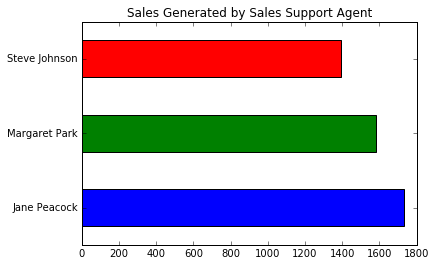

In [18]:
sales_performance = run_query(sales_query)
sales_performance.set_index('employee_name', inplace = True)

sales_performance['total'].plot.barh(
title = 'Sales Generated by Sales Support Agent')

plt.ylabel("")
plt.show()

Jane generated about 24.22% more revenue than Steve. This is possibly because Jane was hired earlier than Steve so she had more time to rack up sales.

### Analyzing Sales by Country

The next task is to look at sales data for customers from each different country. Instead of using the country column from invoice table, we'll be using the country column from the customers table.

In particular, we're going to calculate for each country:
- total number of customers
- total value of sales
- average value of sales per customer
- average order value

In [27]:
sales_query = '''
WITH country_case AS
	(
	SELECT
		CASE
			WHEN (
				SELECT COUNT(*)
				FROM customer
				WHERE country = c.country
				) = 1 THEN "Other"
			ELSE c.country
		END AS country,
		c.customer_id,
		i.invoice_id,
		i.total
	FROM customer AS c
	INNER JOIN invoice AS i ON i.customer_id = c.customer_id
	)
    
SELECT
    country,
    num_customers,
    total_sales,
    value_per_customer,
    value_per_order
FROM
    (
    SELECT
        cc.country AS country,
        COUNT(DISTINCT cc.customer_id) AS num_customers,
        SUM(cc.total) AS total_sales,
        SUM(cc.total) / COUNT(DISTINCT cc.customer_id) AS value_per_customer,
        SUM(cc.total) / COUNT(DISTINCT cc.invoice_id) AS value_per_order,
        CASE
            WHEN cc.country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_case AS cc
    GROUP BY cc.country
    ORDER BY sort ASC, total_sales DESC
    )
'''

In [28]:
run_query(sales_query)

,country,num_customers,total_sales,value_per_customer,value_per_order
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,Czech Republic,2,273.24,136.620000,9.108000
6,United Kingdom,3,245.52,81.840000,8.768571
7,Portugal,2,185.13,92.565000,6.383793
8,India,2,183.15,91.575000,8.721429
9,Other,15,1094.94,72.996000,7.448571


### Visualizing Sales by Country

Now that we have the data, it's time to visualize it. We'll be making recommendations on which country may have potential for growth.

In [37]:
country_sales = run_query(sales_query)
country_sales.set_index('country', inplace = True)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_sales.shape[0])]

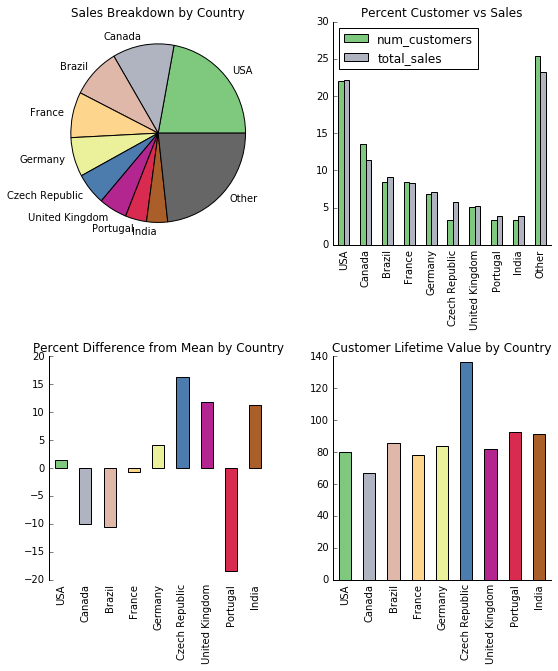

In [80]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(9, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace = 0.5, wspace = 0.3)

# pie chart that breaks down sales by country
country_breakdown = country_sales['total_sales'].copy().rename('')
country_breakdown.plot.pie(
    title = 'Sales Breakdown by Country',
    colormap = plt.cm.Accent,
    ax = ax1
)

# plots the number of customers against sales
customer_vs_dollar = country_sales[['num_customers', 'total_sales']].copy()
customer_vs_dollar.index.name = ''
for c in customer_vs_dollar:
    customer_vs_dollar[c] /= customer_vs_dollar[c].sum() / 100
customer_vs_dollar.plot.bar(
    title = 'Percent Customer vs Sales',
    color = colors,
    ax = ax2
)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.tick_params(top = 'off', right = 'off')

# chart that displays percent difference from mean by country
avg_sales = country_sales['value_per_order'].copy()
avg_sales.index.name = ''
difference_from_avg = (avg_sales - avg_sales.mean()) * 100 / avg_sales.mean()
difference_from_avg.drop('Other', inplace = True)
difference_from_avg.plot.bar(
    title = 'Percent Difference from Mean by Country',
    color = colors,
    ax = ax3
)

ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.tick_params(top = 'off', right = 'off', bottom = 'off')

# plot the customer lifetime value for each country
lifetime = country_sales['value_per_customer'].copy()
lifetime.index.name = ''
lifetime.drop('Other', inplace = True)
lifetime.plot.bar(
    title = 'Customer Lifetime Value by Country',
    color = colors,
    ax = ax4
)

ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.tick_params(top = 'off', right = 'off', bottom = 'off')

plt.show()

Seems Czech Republic, United Kingdom, and India have the highest deviation in sales among the countries. This would be a great area to focus. At the same time, the customer lifetime value for the three countries are among the highest.

### Albums vs Individual Tracks

Customers are allowed to make purchases in one of the two aways:
- purchase a whole album
- purchase a collection of one or more individual tracks

The Chinook store doesn't allow customers to purchase a whole album, then add individual tracks to the same purchase. When customers purchase an album, they are charged the same price as if they added those tracks individually.

The scenario here is management is currently entertaining changing the purchasing strategy to save money. The strategy is to purchase only the most popular track from each album from the record companies, instead of purchasing every song individually.

Our task here is to find out what percentage of purchases are individual tracks versus whole albums.

There are two 'edge cases' to consider:
1. Albums that have only one or two tracks are likely to be purchased by customers as part of a collection of individual tracks.
2. Customers may decide to manually select every track from an album, then add a few individual tracks from other albums to their purchase.

In [81]:
track_query = '''
WITH first_track AS
	(
		SELECT
			il.invoice_id AS invoice_id,
			MIN(il.track_id) AS first_track_id
		FROM invoice_line AS il
		GROUP BY invoice_id
	)

SELECT
	album_purchases,
	COUNT(invoice_id) AS num_of_invoices,
	CAST(COUNT(invoice_id) AS FLOAT) / CAST((SELECT COUNT(*) FROM invoice) AS FLOAT) AS percent_invoices
FROM
	(
	SELECT
		first_track.*,
		CASE
			WHEN
				(	
				SELECT t.track_id
				FROM track AS t
				WHERE t.album_id = (
									SELECT t2.album_id
									FROM track AS t2
									WHERE t2.track_id = first_track.first_track_id
									)
				EXCEPT

				SELECT il.track_id
				FROM invoice_line AS il
				WHERE il.invoice_id = first_track.invoice_id	
				) IS NULL
			AND
				(
				SELECT il.track_id
				FROM invoice_line AS il
				WHERE il.invoice_id = first_track.invoice_id
				
				EXCEPT
				
				SELECT t.track_id
				FROM track AS t
				WHERE t.album_id = (
									SELECT t2.album_id
									FROM track AS t2
									WHERE t2.track_id = first_track.first_track_id
									)
				) IS NULL
			THEN 'yes'
			ELSE 'no'
		END AS 'album_purchases'
	FROM first_track
	)
GROUP BY album_purchases
'''

In [82]:
run_query(track_query)

,album_purchases,num_of_invoices,percent_invoices
0,no,500,0.814332
1,yes,114,0.185668


Album purchases take up 18.57% of total purchases. As this is a sizable amount, I'd advise against Chinook purchasing individual tracks.